In [5]:
import torch
import numpy as np
from tqdm import tqdm, trange
from nnsight import LanguageModel
import matplotlib.pyplot as plt
import pandas as pd
import os
from huggingface_hub import login
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import pickle
from sklearn.exceptions import ConvergenceWarning
import warnings
import itertools
import json


In [28]:
MAX_INT_TOKEN = {
    'gpt-j-6B': 361,
    'Llama-3.1-8B': 999,
    'pythia-6.9b': 557    
}
OPERATION = 'multiplication'
assert OPERATION in ['addition', 'multiplication']
mina = 0 if OPERATION == 'addition' else 1
if OPERATION == 'multiplication':
    op = "*"
else:
    op = "+"


# Load the model

In [7]:
# Load model# Set the token as an environment variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
full_model_name = 'EleutherAI/gpt-j-6B'#'meta-llama/Llama-3.1-8B'# #'EleutherAI/pythia-6.9b'## # #'google/gemma-2-9b'#'
MODEL_NAME = full_model_name.split('/')[-1]
model = LanguageModel(full_model_name, device_map=device, torch_dtype=torch.bfloat16, dispatch=True)
remote = False
NLAYERS = model.config.num_hidden_layers

Some weights of the model checkpoint at EleutherAI/gpt-j-6B were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.20.attn.bi

# Generate Expressions and Evaluate the Model

In [31]:
np.random.seed(42)
def gen_math(mina = mina, maxa = 99):
    """Generates the questions and expected answers for the addition problem"""
    data = []
    with torch.no_grad():
        for a in tqdm(range(mina, maxa + 1)):
            for b in range(mina, maxa + 1):
                if MODEL_NAME == 'gpt-j-6B':
                    q_string = f'Output ONLY a number.\n{a}{op}{b}='
                elif MODEL_NAME == 'Llama-3.1-8B':
                    q_string = f'The following is a correct {OPERATION} problem. \n{a}{op}{b}='
                elif MODEL_NAME == 'pythia-6.9b':
                    q_string = f'Output ONLY a number. {a}{op}{b}='
                q_toks = model.tokenizer(q_string)['input_ids']
                if OPERATION == 'multiplication':
                    answer = a*b
                    if answer > MAX_INT_TOKEN[MODEL_NAME]:
                        continue
                else:
                    answer = a+b
                answer_tok = model.tokenizer(f'{answer}')['input_ids']
                if MODEL_NAME == 'Llama-3.1-8B':
                    answer_tok = [answer_tok[-1]]
                #print(answer_tok)
                data.append({
                    'a': a,
                    'b': b,
                    'q_string': q_string,
                    'q_tok': q_toks,
                    'answer': answer,
                    'answer_tok': answer_tok
                })
    df = pd.DataFrame(data)
    df.to_pickle(f'data_{OPERATION}/gen_math/data_{OPERATION}_{mina}_{maxa}_{MODEL_NAME}.pkl')
    return df


#evaluate_math(mina = 0, maxa = 500)
gen_math(mina = mina, maxa = 99)
#data = get_math_gen()

100%|██████████| 99/99 [00:00<00:00, 181.90it/s]


,a,b,q_string,q_tok,answer,answer_tok
0,1,1,Output ONLY a number.\n1*1=,"[26410, 22224, 257, 1271, 13, 198, 16, 9, 16, 28]",1,[16]
1,1,2,Output ONLY a number.\n1*2=,"[26410, 22224, 257, 1271, 13, 198, 16, 9, 17, 28]",2,[17]
2,1,3,Output ONLY a number.\n1*3=,"[26410, 22224, 257, 1271, 13, 198, 16, 9, 18, 28]",3,[18]
3,1,4,Output ONLY a number.\n1*4=,"[26410, 22224, 257, 1271, 13, 198, 16, 9, 19, 28]",4,[19]
4,1,5,Output ONLY a number.\n1*5=,"[26410, 22224, 257, 1271, 13, 198, 16, 9, 20, 28]",5,[20]
...,...,...,...,...,...,...
1456,98,2,Output ONLY a number.\n98*2=,"[26410, 22224, 257, 1271, 13, 198, 4089, 9, 17...",196,[25272]
1457,98,3,Output ONLY a number.\n98*3=,"[26410, 22224, 257, 1271, 13, 198, 4089, 9, 18...",294,[27696]
1458,99,1,Output ONLY a number.\n99*1=,"[26410, 22224, 257, 1271, 13, 198, 2079, 9, 16...",99,[2079]
1459,99,2,Output ONLY a number.\n99*2=,"[26410, 22224, 257, 1271, 13, 198, 2079, 9, 17...",198,[22337]


100%|██████████| 15/15 [00:01<00:00,  9.68it/s, %=0.988]


Accuracy for numbers up to 25: 85.49%
Accuracy for numbers up to 50: 82.78%
Accuracy for numbers up to 75: 81.61%
Accuracy for numbers up to 100: 80.97%


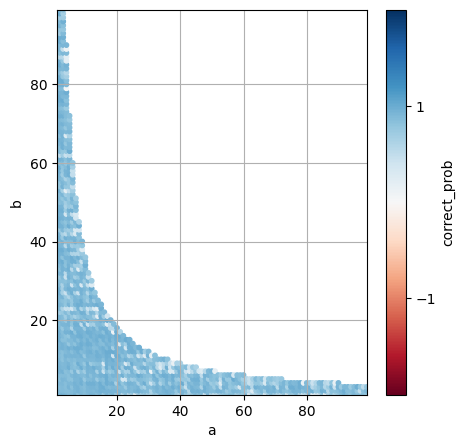

In [32]:
def evaluate_math(mina = mina, maxa = 99, verbose = False, batch_size = 100):
    """Evaluates the model on the addition problem, and just record if it was correct or not (per batch)."""
    df = pd.read_pickle(f'data_{OPERATION}/gen_math/data_{OPERATION}_{mina}_{maxa}_{MODEL_NAME}.pkl')
    #df = df.sample(n=15, random_state=42)
    corrects = []
    correct_probs = []
    with torch.no_grad():
        # Process rows in batches
        bar = tqdm(range(0, len(df), batch_size))
        for step in bar:
            batch_df = df.iloc[step:min(step + batch_size, len(df))]
            batch_toks = torch.stack([torch.tensor(x) for x in batch_df['q_tok'].values]).to(device)
            # Combine into single batch tensor
            answer_toks = torch.stack([torch.tensor(x)[0] for x in batch_df['answer_tok'].values])
            # Get model outputs for batch
            with model.trace() as tracer:
                with tracer.invoke(batch_toks) as invoker:
                    pass
                output = model.output.save()
            
            # Get predictions for batch
            logits = output.logits[:,-1].cpu()
            #print(model.tokenizer.batch_decode(output.logits[0].argmax(dim=-1)))
            model_answers = logits.argmax(dim=-1)
            probs = torch.softmax(logits, -1)

            correct = (model_answers == answer_toks).float()
            correct_prob = torch.gather(probs, -1, answer_toks[:,None])[:, 0]
            #correct = probs[:, answer_toks]
            incorrect_mask = correct == 0
            if incorrect_mask.any() and verbose:
                print("Incorrect answers:")
                print("Expected:", model.tokenizer.batch_decode(answer_toks[incorrect_mask].unsqueeze(-1)))
                print("Got:", model.tokenizer.batch_decode(model_answers[incorrect_mask].unsqueeze(-1)))
            corrects.extend(list(correct))
            correct_probs.extend(list(correct_prob))
            bar.set_postfix({'%': np.mean(corrects)})
            
    df['correct'] = corrects
    df['correct_prob'] = correct_probs
    df.to_pickle(f'data_{OPERATION}/gen_math/data_{OPERATION}_correct_{mina}_{maxa}_{MODEL_NAME}.pkl')
    return np.mean(corrects)

def plot_math_results(mina = mina, maxa = 99):    
    model_name = MODEL_NAME
    df = pd.read_pickle(f'data_{OPERATION}/gen_math/data_{OPERATION}_correct_{mina}_{maxa}_{MODEL_NAME}.pkl')

    plot_type = 'correct_prob'#'correct'
    
    # Print accuracies for different ranges
    for max_val in [25, 50, 75, 100]:
        filtered_df = df[(df['a'] <= max_val) & (df['b'] <= max_val)]
        acc = 100 * np.mean(filtered_df[plot_type])
        print(f"Accuracy for numbers up to {max_val}: {acc:.2f}%")
    
    plt.figure(figsize=(5, 5))
    # Create a scatter plot
    scatter = plt.scatter(df['a'], df['b'], c=df[plot_type].replace({1: 1, 0: -1}), cmap='RdBu', s=10, vmin = -2, vmax = 2)
    # Add colorbar
    plt.colorbar(scatter, ticks=[-1, 1], label=plot_type)
    # plt.title(f'{model_name} Results on a+b= (Blue if correct)\n{100*np.mean(df['correct']):.2f}% Correct')
    plt.xlabel('a')
    plt.ylabel('b')
    plt.xlim(mina, maxa)
    plt.ylim(mina, maxa)
    plt.grid(True)
    plt.show()


evaluate_math(mina = mina, maxa = 99, verbose = False)
plot_math_results()

# Helper Functions to get the Correct Data

In [33]:
def get_correct_df(mina = mina, maxa = 99):
    df = pd.read_pickle(f'data_{OPERATION}/gen_math/data_{OPERATION}_correct_{mina}_{maxa}_{MODEL_NAME}.pkl')
    return df[df['correct'] == 1]

def get_df_sample(mina = mina, maxa = 99, num_sample = 500, run = False):
    if run:
        df = get_correct_df(mina, maxa)
        df = df.sample(n=num_sample, random_state=42).reset_index(drop=True)
        # Save sampled dataframe
        save_path = f'data_{OPERATION}/gen_math/data_{OPERATION}_correct_sample_{mina}_{maxa}_{MODEL_NAME}.pkl'
        df.to_pickle(save_path)
    return pd.read_pickle(f'data_{OPERATION}/gen_math/data_{OPERATION}_correct_sample_{mina}_{maxa}_{MODEL_NAME}.pkl')

def get_output_tokens(mina = mina, maxa = 99):
    # answers range from 0, 99 * 2 
    avals, toks = [], []
    for a in range(mina, 2 * maxa + 1):
        atok = model.tokenizer(f'{a}')['input_ids']
        avals.append(a)
        toks.append(atok[0])
    return avals, toks

a, toks = get_output_tokens()
get_df_sample(run = True)


,a,b,q_string,q_tok,answer,answer_tok,correct,correct_prob
0,5,32,Output ONLY a number.\n5*32=,"[26410, 22224, 257, 1271, 13, 198, 20, 9, 2624...",160,[14198],tensor(1.),tensor(0.9197)
1,4,21,Output ONLY a number.\n4*21=,"[26410, 22224, 257, 1271, 13, 198, 19, 9, 2481...",84,[5705],tensor(1.),tensor(0.6891)
2,29,1,Output ONLY a number.\n29*1=,"[26410, 22224, 257, 1271, 13, 198, 1959, 9, 16...",29,[1959],tensor(1.),tensor(0.7426)
3,1,67,Output ONLY a number.\n1*67=,"[26410, 22224, 257, 1271, 13, 198, 16, 9, 3134...",67,[3134],tensor(1.),tensor(0.3680)
4,28,3,Output ONLY a number.\n28*3=,"[26410, 22224, 257, 1271, 13, 198, 2078, 9, 18...",84,[5705],tensor(1.),tensor(0.7604)
...,...,...,...,...,...,...,...,...
495,78,1,Output ONLY a number.\n78*1=,"[26410, 22224, 257, 1271, 13, 198, 3695, 9, 16...",78,[3695],tensor(1.),tensor(0.6026)
496,61,2,Output ONLY a number.\n61*2=,"[26410, 22224, 257, 1271, 13, 198, 5333, 9, 17...",122,[18376],tensor(1.),tensor(0.7314)
497,16,17,Output ONLY a number.\n16*17=,"[26410, 22224, 257, 1271, 13, 198, 1433, 9, 15...",272,[29807],tensor(1.),tensor(0.8180)
498,3,70,Output ONLY a number.\n3*70=,"[26410, 22224, 257, 1271, 13, 198, 18, 9, 2154...",210,[21536],tensor(1.),tensor(0.9431)


# Helper function to get hidden states

In [36]:
ANS_SEQPOS_DICT = {'a': -4, 'b':-2, 'a+b':-1}
def run_hs(target, mina = mina, maxa = 99, batch_size = 80, sample = False):
    """Gets the hidden states for the target token."""
    ANS_SEQPOS = ANS_SEQPOS_DICT[target]
    if sample:
        df = get_df_sample(mina, maxa, run = False)
    else:
        df = get_correct_df(mina, maxa)
    a = torch.tensor(df['a'].values)
    b = torch.tensor(df['b'].values)
    if OPERATION == 'multiplication':
        a_b = a*b
    else:
        a_b = a+b
    hss = []
    with torch.no_grad():
        for step in tqdm(range(0, len(df), batch_size)):
            batch_df = df.iloc[step:min(step + batch_size, len(df))]
            tokens = torch.stack([torch.tensor(x) for x in batch_df['q_tok'].values]).to(device)
            layer_hss = []
            with model.trace(validate=False,remote=remote) as tracer:
                with tracer.invoke(tokens, scan=False):
                    for layer in range(NLAYERS):
                        if MODEL_NAME == 'Llama-3.1-8B':
                            hs = model.model.layers[layer].input
                        elif MODEL_NAME == 'gpt-j-6B':
                            hs = model.transformer.h[layer].inputs[1]['hidden_states']
                        elif MODEL_NAME == 'pythia-6.9b':
                            hs = model.gpt_neox.layers[layer].input
                        layer_hss.append(hs[:,ANS_SEQPOS].save())
            layer_hss = [layer_hs.detach().cpu() for layer_hs in layer_hss] # gets hs on top of ans_token
            layer_hss = torch.stack(layer_hss, dim=1) # stack along new layer dimension
            hss.append(layer_hss)
    hss = torch.cat(hss, dim=0) # concat along batch dimension
    # Save nums and hss to file with descriptive name
    # Use _FULL in filename if using complete dataset
    suffix = '_FULL' if not sample else ''
    save_path = f'data_{OPERATION}/helix_hss/{target}_helix_data_{mina}_{maxa}{suffix}_{MODEL_NAME}.pt'
    # Create directory if it doesn't exist
    os.makedirs(f'data_{OPERATION}/helix_hss', exist_ok=True)
    # Save tensors
    torch.save({
        'a': a,
        'b':b,
        'a+b':a_b,
        'hidden_states': hss
    }, save_path)
    return a,b,a_b, hss

def get_nums_hss(target, mina = 0,maxa = 99, sample = True):
    suffix = '_FULL' if not sample else ''
    save_path = f'data_{OPERATION}/helix_hss/{target}_helix_data_{mina}_{maxa}{suffix}_{MODEL_NAME}.pt'
    obj = torch.load(save_path, weights_only=True)
    a,b,a_b, hss = obj['a'], obj['b'], obj['a+b'], obj['hidden_states']
    return a,b,a_b, hss

# run_hs('a', sample = False)
# run_hs('a', sample = True)
# run_hs('b', sample = False)
# run_hs('b', sample = True)
# run_hs('a+b', sample = False)
# run_hs('a+b', sample = True)
get_nums_hss('a', sample = True)

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00,  8.96it/s]


(tensor([ 8, 46, 18,  6, 53, 20, 87, 43, 35,  2,  4, 87, 21, 92,  8,  4,  4,  5,
         23,  6,  5,  8, 26, 61,  6, 52,  4,  4, 13,  0, 10,  2, 21,  3, 55, 73,
          9,  2,  0, 38,  2, 15,  6,  0,  3, 63,  5,  5,  2,  3,  3, 29,  5, 15,
         27,  4,  3,  4,  0,  6, 28,  1, 15,  0,  2,  0, 22,  1,  4, 96, 20, 32,
         60, 29,  3, 14, 65, 42,  0, 56,  0, 47, 29, 65,  2, 44, 30, 13, 68,  1,
         25, 18, 26,  2,  0,  3,  5, 45, 10,  9,  8, 29, 14, 31, 44, 95, 21,  9,
          6, 27,  4, 10,  3, 15, 91, 35, 48, 42, 38,  6, 39,  2,  0, 27, 34, 10,
          4,  9, 97,  3, 22, 12, 12,  4,  1,  7,  8,  4,  8, 95, 11,  0,  1,  4,
         17,  6, 16, 17,  2, 27,  0,  0, 54,  3,  1,  3, 36, 40,  1, 20,  1,  8,
         25,  6, 83,  2, 62,  6, 57, 10,  0,  4, 12,  1,  3, 58, 20, 65,  6, 51,
          7, 33,  7, 11, 75, 82,  1, 49,  4,  4, 11, 82, 19, 74,  5, 48, 12,  4,
          3, 12, 22,  4,  9,  2, 70, 28,  4, 44, 15, 36, 10,  3, 47, 20,  6,  2,
         12, 46,  1, 25, 43,

# PCA Functions
These functions generate the PCA for all hidden states to be used for helix fitting and downstream interventions

In [ ]:
def run_pca(target, mina = mina, maxa = 99, NUM_PCA = 100):
    _,_,_, hss = get_nums_hss(target, mina, maxa) # we want the full thing for a pca
    pca_components = {}
    for layer in tqdm(range(hss.shape[1])):
        hs = hss[:,layer]
        # Convert to numpy for sklearn
        hs_numpy = hs.float().numpy()
        # Fit PCA without dimensionality reduction
        pca = PCA(n_components=NUM_PCA)# None
        pca.fit(hs_numpy)
        # Store components for this layer
        pca_components[layer] = {
            'explained_variance_ratio': pca.explained_variance_ratio_,
            'components': pca.components_,
            'singular_values': pca.singular_values_,
            'mean': pca.mean_
        }
    # Save PCA components to file with descriptive name
    save_path = f'data_{OPERATION}/helix_pca/{target}_pca_data_{mina}_{maxa}_{MODEL_NAME}.pt'
    # Create directory if it doesn't exist
    os.makedirs(f'data_{OPERATION}/helix_pca', exist_ok=True)
    # Save dictionary
    torch.save(pca_components, save_path)
    return pca_components

def get_pca(target, layer, mina = 0, maxa = 99):
    save_path = f'data_{OPERATION}/helix_pca/{target}_pca_data_{mina}_{maxa}_{MODEL_NAME}.pt'
    pca_data = torch.load(save_path, weights_only = False)[layer]
    return pca_data

run_pca('a')
run_pca('b')
get_pca('b', 18)

  0%|          | 0/28 [00:00<?, ?it/s]

 75%|███████▌  | 21/28 [04:14<01:23, 11.88s/it]

In [41]:
def get_pca_coords(target, layer, mina = mina, maxa = 99, npca = False, reconstruction = False):
    """Expresses hidden states of target at layer in PCA space.
    npca: filter to top components
    reconstruction: reconstruct hidden states from PCA space, instead of returning PCA coordinates.
    """
    assert isinstance(npca, bool) or isinstance(npca, int), "npca must be either False or an integer"
    a,b,a_b, hss = get_nums_hss(target, mina, maxa, sample = True) # just take subset
    hss = hss[:,layer]
    pca_data = get_pca(target, layer, mina, maxa)
    pca_comps, pca_mean = pca_data['components'], pca_data['mean']
    #print(hss.shape, pca_comps.shape)
    #assert hss.shape[0] == pca_comps.shape[0] # same batch
    # Project data into PCA space
    hs_numpy = hss.float().numpy()
    hs_centered = hs_numpy - pca_mean
    pca_coords = np.dot(hs_centered, pca_comps.T)
    if npca is False:
        npca = hss.shape[0] # make it full batch
    pca_coords = pca_coords[:, :npca]
    if reconstruction:
        reconstruction = torch.tensor(np.dot(pca_coords, pca_comps[:npca]) + pca_mean)
        mse = torch.mean((reconstruction - hss) ** 2)
        #print(f"MSE between reconstruction and original hidden states: {mse:.6f}")
        return a,b,a_b, reconstruction
    else:
        return a,b,a_b, pca_coords

s = get_pca_coords('a', 1, npca = 3, reconstruction=True)

# Helix Time

In [46]:
def create_features(fit_type, nums, bases = [2,5,10,100], polybase = 9):
    """creates the basis of features of helix regression (and other regression types)"""
    assert fit_type in ['helix', 'poly', 'circle', 'loghelix', 'logcircle', 'logpoly']
    feature_list = []
    for i, num in enumerate(nums):
        mnum = max(num)
        scaled_num = num / mnum
        if fit_type == 'helix' or fit_type == 'circle':
            for base in bases:
                t_scaled = 2 * np.pi * num / base
                feature_list.extend([np.cos(t_scaled), np.sin(t_scaled)])
        if fit_type == 'helix':
            feature_list.append(scaled_num)  # Add linear term for helix
        if fit_type == 'poly':
            feature_list = [num**power for power in range(1,polybase + 1)]
        if fit_type == 'loghelix' or fit_type == 'logcircle':
            for base in bases:
                t_scaled = 2 * np.pi * np.log(num) / base
                feature_list.extend([np.cos(t_scaled), np.sin(t_scaled)])
        if fit_type == 'loghelix':
            feature_list.append(np.log(scaled_num))
        if fit_type == 'logpoly':
            feature_list = [np.log(num)**power for power in range(1,polybase + 1)]
    feature_list.append(np.ones(nums.shape[1])) # bias term
    helix_features = np.column_stack(feature_list)
    return helix_features



In [59]:
def get_train_test_split(frac=0.75):
    """Returns which values of a (0-99) are in train vs test sets"""
    a_values = np.arange(100)
    n_train = int(100 * frac)
    train_a = np.random.choice(a_values, size=n_train, replace=False)
    return train_a

def get_train_mask(a, frac = 0.75):
    train_a = get_train_test_split(frac)
    """Returns boolean mask indicating which elements of a are in training set"""
    return np.isin(a, train_a)

def helix_fit(layer, helix_type, bases=[2,5,10,100], polybase=9, save=True, traintest=False, random=False):
    """Performs linear regression for a specific layer, fit_type and target.
       The dependent variables, the "features" are a simple functions of the input numbers.
       The independent variables are the hidden states of the target token, reduced to a PCA space.
      ."""
    # target is whatever comes after helix_ in helix_type
    # fitting the helix
    fit_type, target = helix_type.split('_', 1)
    a,b,a_b, hss_projected_n = get_pca_coords(target, layer, mina=mina, maxa=99, npca=False, reconstruction=False)
    hss_original = get_nums_hss(target, mina=mina, maxa=99)[-1][:,layer]
    pca_data = get_pca(target, layer, mina=mina, maxa=99)
    pca_comp, pca_mean = pca_data['components'], pca_data['mean']

    if target == 'a_b':
        nums = np.array([a,b])
    elif target == 'a':
        nums = np.array([a])
    elif target == 'b':
        nums = np.array([b])
    helix_features = create_features(fit_type, nums, bases=bases, polybase=polybase)
    
    # Split data for train/test if requested
    train_mask = None
    if traintest:
        train_mask = get_train_mask(a)
        train_features = helix_features[train_mask]
        train_targets = hss_projected_n[train_mask]
    else:
        train_features = helix_features
        train_targets = hss_projected_n
    
    if random:
        np.random.shuffle(train_features)
    #print(train_features)
        
    # Fit a separate linear model for each reduced dimension
    weights_by_dim = []
    predictions = np.zeros_like(hss_projected_n)
    models = []

    # Suppress convergence warnings during model fitting
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=ConvergenceWarning)
        for i in range(hss_projected_n.shape[1]):
            model = LinearRegression(fit_intercept=False)
            #model = Lasso(alpha=0.01, fit_intercept=False)
            model.fit(train_features, train_targets[:, i])
            models.append(model)
            weights_by_dim.append(model.coef_)
            predictions[:, i] = model.predict(helix_features)  # Predict on all data
            
    # Transform predictions back to original space using SVD components
    predictions_full_space = np.dot(predictions, pca_comp) + pca_mean
    # Calculate MSE in original space
    mse = np.mean((predictions_full_space - hss_original.float().numpy()) ** 2)
    A = np.stack(weights_by_dim, axis=-1)  # Stack weights to form the matrix A
    A_map = A @ pca_comp # 28, 4096

    if save:
        save_dir = f'data_{OPERATION}/helix_fit/trained_fit'
        os.makedirs(save_dir, exist_ok=True)
        if fit_type == 'poly' or fit_type == 'logpoly':
            helix_type = f'{helix_type}_{polybase}'
        else:
            helix_type = f'{helix_type}_{bases}'
        if random:
            helix_type = f'{helix_type}_random'
        os.makedirs(os.path.join(save_dir, helix_type), exist_ok=True)
        save_path = f"{save_dir}/{helix_type}/{helix_type}_fit_layer{layer}_{MODEL_NAME}{'_traintest' if traintest else ''}.pkl"
        with open(save_path, 'wb') as f:
            save_dict = {
                'a': a,
                'b': b,
                'a+b': a_b,
                'predictions_full': predictions_full_space,
                'A_map': A_map,
                'pca_mean': pca_mean,
                'mse': mse
            }
            pickle.dump(save_dict, f)
    return nums, predictions_full_space, mse, train_mask if traintest else None

# x = helix_fit(layer=0, helix_type='helix_a', random = True)
x = helix_fit(layer=0, helix_type='logpoly_a', polybase=1, random = True)
x = helix_fit(layer=1, helix_type='logpoly_a', polybase=1, random = True)
#get_features([[1,2,3,4,5],[2,3,4,5,6], [3,5,7,9,11]], 'poly', [2,5,10,100]).shape
x[-2]

np.float32(0.03737689)

In [36]:
nums, predictions_full_space, mse, train_mask = x


In [87]:
def get_bases_perms():
    bases_list = [2, 5, 10, 100]
    all_perms = []
    # Add all lengths of combinations
    for length in range(1, len(bases_list) + 1):
        combs = list(itertools.combinations(bases_list, length))
        all_perms.extend(combs)
    # Convert tuples to lists
    all_perms = [list(p) for p in all_perms]
    return all_perms

def run_all_fits():
    for layer in tqdm(range(NLAYERS)):
        for polybase in [1,3,5,7,9]:
            helix_fit(layer = layer, helix_type = 'poly_a', polybase=polybase)
        for bases in get_bases_perms():
            helix_fit(layer = layer, helix_type = 'circle_a', bases=bases)
            helix_fit(layer = layer, helix_type = 'helix_a', bases = bases)


def run_all_log_fits():
    for layer in tqdm(range(NLAYERS)):
        for polybase in [1,3,5,7,9]:
            helix_fit(layer = layer, helix_type = 'logpoly_a', polybase=polybase)
        for bases in get_bases_perms():
            helix_fit(layer = layer, helix_type = 'logcircle_a', bases=bases)
            helix_fit(layer = layer, helix_type = 'loghelix_a', bases = bases)

def run_train_test_fits():
     for layer in tqdm(range(NLAYERS)):
        helix_fit(layer = layer, helix_type = 'poly_a', polybase=9, traintest = True)
        helix_fit(layer = layer, helix_type = 'circle_a', bases=[2,5,10,100], traintest = True)
        helix_fit(layer = layer, helix_type = 'helix_a', bases = [2,5,10,100], traintest = True)

def run_fits_b():
    for layer in tqdm(range(NLAYERS)):
        helix_fit(layer = layer, helix_type = 'poly_b', polybase=9)
        helix_fit(layer = layer, helix_type = 'circle_b', bases=[2,5,10,100])
        helix_fit(layer = layer, helix_type = 'helix_b', bases = [2,5,10,100])

def run_random_fits():
    for layer in tqdm(range(NLAYERS)):
        helix_fit(layer = layer, helix_type = 'helix_a', bases = [2,5,10,100], random = True)
# run_all_fits()
#run_train_test_fits()
#run_fits_b()
# run_all_fits()
run_all_log_fits()

  7%|▋         | 2/28 [00:32<07:02, 16.26s/it]


KeyError: 2

In [64]:
print(pickle.load(open('data_multiplication/helix_fit/trained_fit/logpoly_a_1_random/logpoly_a_1_random_fit_layer1_gpt-j-6B.pkl', 'rb'))['mse'])
print(pickle.load(open('data_multiplication/helix_fit/trained_fit/logpoly_a_1/logpoly_a_1_fit_layer1_gpt-j-6B.pkl', 'rb'))['mse'])
print(pickle.load(open('data_multiplication/helix_fit/trained_fit/poly_a_1/poly_a_1_fit_layer1_gpt-j-6B.pkl', 'rb'))['mse'])
print(pickle.load(open('data_multiplication/helix_fit/trained_fit/helix_a_[2, 5, 10, 100]/helix_a_[2, 5, 10, 100]_fit_layer1_gpt-j-6B.pkl', 'rb'))['mse'])

0.03737689
0.031834338
0.032897662
0.020943325


# Intervention Helper Functions

In [65]:
def pca_projection(target,nums, npca, mina, maxa, layer):
    a,b,a_b, reconstruction = get_pca_coords(target, layer, mina, maxa, npca = npca, reconstruction = True)
    # Find matching indices using a for loop
    allnums = np.array([a,b,a_b])
    # Convert nums to 3xM array if needed
    nums = np.array(nums)
    # For each column in nums, find matching column in allnums
    matching_indices = []
    for i in range(nums.shape[1]):
        num_col = nums[:,i]
        # Find where this column appears in allnums
        for j in range(allnums.shape[1]):
            if np.array_equal(allnums[:,j], num_col):
                matching_indices.append(j)
                break
        else:
            raise ValueError(f"No matching column found in allnums for nums column {num_col}")
            
    # Return tensor of predictions for matching indices
    return reconstruction[matching_indices]

#pca_projection('a',[[32,77,32],[56,0,56],[88,77,88]], mina = 0, maxa = 99, layer = 0, npca=100)

In [66]:
def find_fit(helix_type, layer, traintest = False):
    save_dir = f'data_{OPERATION}/helix_fit/trained_fit'
    save_path = f"{save_dir}/{helix_type}/{helix_type}_fit_layer{layer}_{MODEL_NAME}{'_traintest' if traintest else ''}.pkl"
    with open(save_path, 'rb') as f:
        data = pickle.load(f)
    return data

def get_fit(nums, helix_type, layer, traintest = False):
    data = find_fit(helix_type, layer, traintest)
    a,b,a_b, allhss = data['a'],data['b'],data['a+b'], data['predictions_full']
    allnums = np.array([a,b,a_b])
    
    # Convert nums to 3xM array if needed
    nums = np.array(nums)
    # For each column in nums, find matching column in allnums
    matching_indices = []
    for i in range(nums.shape[1]):
        num_col = nums[:,i]
        # Find where this column appears in allnums
        for j in range(allnums.shape[1]):
            if np.array_equal(allnums[:,j], num_col):
                matching_indices.append(j)
                break
        else:
            raise ValueError(f"No matching column found in allnums for nums column {num_col}")
            
    # Return tensor of predictions for matching indices
    return torch.tensor(allhss[matching_indices])


# Run Interventions

In [ ]:
def gen_intervention(target, mina, maxa, samplesize = 1000, run = False):
    """Like gen_math, but makes pairs of questions (one to use as the corrupted)"""
    if run:
        df = get_df_sample(mina, maxa, run = False)
        # Create cartesian product of df with itself
        intervention_df = df.merge(df, how='cross', suffixes=('_original', '_intervened'))
        # Filter out cases where original answer equals intervened answer
        if target == 'a':
            intervention_df = intervention_df[
                (intervention_df['answer_original'] != intervention_df['answer_intervened']) &
                (intervention_df['a_original'] != intervention_df['a_intervened']) &
                (intervention_df['b_original'] == intervention_df['b_intervened'])
            ]
        elif target == 'b':
            intervention_df = intervention_df[
                (intervention_df['answer_original'] != intervention_df['answer_intervened']) &
                (intervention_df['a_original'] == intervention_df['a_intervened']) &
                (intervention_df['b_original'] != intervention_df['b_intervened'])
            ]
        else: raise ValueError('bad target')
        # Take random sample of size samplesize
        if samplesize < len(intervention_df):
            intervention_df = intervention_df.sample(n=samplesize, random_state=42).reset_index(drop = True)
        # Save to pickle file
        intervention_df.to_pickle(f'data_{OPERATION}/gen_math/data_intervention_{mina}_{maxa}_sample{samplesize}_{MODEL_NAME}_{target}.pkl')
    intervention_df = pd.read_pickle(f'data_{OPERATION}/gen_math/data_intervention_{mina}_{maxa}_sample{samplesize}_{MODEL_NAME}_{target}.pkl')
    return intervention_df

# gen_intervention('a', mina, 99, run = True)
# gen_intervention('b', mina, 99, run = True)


,a_original,b_original,q_string_original,q_tok_original,answer_original,answer_tok_original,correct_original,correct_prob_original,a_intervened,b_intervened,q_string_intervened,q_tok_intervened,answer_intervened,answer_tok_intervened,correct_intervened,correct_prob_intervened
0,8,19,Output ONLY a number.\n8*19=,"[26410, 22224, 257, 1271, 13, 198, 23, 9, 1129...",152,[17827],tensor(1.),tensor(0.9648),8,35,Output ONLY a number.\n8*35=,"[26410, 22224, 257, 1271, 13, 198, 23, 9, 2327...",280,[21033],tensor(1.),tensor(0.8561)
1,3,22,Output ONLY a number.\n3*22=,"[26410, 22224, 257, 1271, 13, 198, 18, 9, 1828...",66,[2791],tensor(1.),tensor(0.7525),3,13,Output ONLY a number.\n3*13=,"[26410, 22224, 257, 1271, 13, 198, 18, 9, 1485...",39,[2670],tensor(1.),tensor(0.9475)
2,4,76,Output ONLY a number.\n4*76=,"[26410, 22224, 257, 1271, 13, 198, 19, 9, 4304...",304,[21288],tensor(1.),tensor(0.8291),4,84,Output ONLY a number.\n4*84=,"[26410, 22224, 257, 1271, 13, 198, 19, 9, 5705...",336,[29211],tensor(1.),tensor(0.9181)
3,1,80,Output ONLY a number.\n1*80=,"[26410, 22224, 257, 1271, 13, 198, 16, 9, 1795...",80,[1795],tensor(1.),tensor(0.7771),1,98,Output ONLY a number.\n1*98=,"[26410, 22224, 257, 1271, 13, 198, 16, 9, 4089...",98,[4089],tensor(1.),tensor(0.8526)
4,3,22,Output ONLY a number.\n3*22=,"[26410, 22224, 257, 1271, 13, 198, 18, 9, 1828...",66,[2791],tensor(1.),tensor(0.7525),3,70,Output ONLY a number.\n3*70=,"[26410, 22224, 257, 1271, 13, 198, 18, 9, 2154...",210,[21536],tensor(1.),tensor(0.9431)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,45,Output ONLY a number.\n1*45=,"[26410, 22224, 257, 1271, 13, 198, 16, 9, 2231...",45,[2231],tensor(1.),tensor(0.8985),1,31,Output ONLY a number.\n1*31=,"[26410, 22224, 257, 1271, 13, 198, 16, 9, 3132...",31,[3132],tensor(1.),tensor(0.5705)
996,4,14,Output ONLY a number.\n4*14=,"[26410, 22224, 257, 1271, 13, 198, 19, 9, 1415...",56,[3980],tensor(1.),tensor(0.8929),4,81,Output ONLY a number.\n4*81=,"[26410, 22224, 257, 1271, 13, 198, 19, 9, 6659...",324,[33916],tensor(1.),tensor(0.8478)
997,1,30,Output ONLY a number.\n1*30=,"[26410, 22224, 257, 1271, 13, 198, 16, 9, 1270...",30,[1270],tensor(1.),tensor(0.6590),1,56,Output ONLY a number.\n1*56=,"[26410, 22224, 257, 1271, 13, 198, 16, 9, 3980...",56,[3980],tensor(1.),tensor(0.7637)
998,4,56,Output ONLY a number.\n4*56=,"[26410, 22224, 257, 1271, 13, 198, 19, 9, 3980...",224,[24137],tensor(1.),tensor(0.6311),4,27,Output ONLY a number.\n4*27=,"[26410, 22224, 257, 1271, 13, 198, 19, 9, 1983...",108,[15711],tensor(1.),tensor(0.4404)


In [68]:
# Metrics
def calc_log_diff(original_logits, patched_logits, patched_answer_tokens):
    return patched_logits[range(len(patched_logits)), patched_answer_tokens] - original_logits[range(len(original_logits)), patched_answer_tokens]

def calc_accuracy(patched_logits, patched_answer_tokens):
    model_answers = patched_logits.argmax(dim=-1)
    correct = (model_answers == patched_answer_tokens).int()
    return correct


def calc_proxy_accuracy(original_logits, patched_logits, patched_answer_tokens):
    patched_maximal_logit = patched_logits.max(dim=-1).values
    patched_answer_logit = patched_logits[range(len(patched_logits)), patched_answer_tokens]
    original_maximal_logit = original_logits.max(dim=-1).values
    original_answer_logit = original_logits[range(len(patched_logits)), patched_answer_tokens]
    original_proxy, patched_proxy = original_answer_logit/original_maximal_logit, patched_answer_logit/patched_maximal_logit
    return patched_proxy-original_proxy

def calc_log_diff_max(original_logits, patched_logits, patched_answer_tokens):
    patched_maximal_logit = patched_logits.max(dim=-1).values
    patched_answer_logit = patched_logits[range(len(patched_logits)), patched_answer_tokens]
    original_maximal_logit = original_logits.max(dim=-1).values
    original_answer_logit = original_logits[range(len(patched_logits)), patched_answer_tokens]
    patched_diff = patched_answer_logit - patched_maximal_logit
    original_diff = original_answer_logit - original_maximal_logit
    return patched_diff - original_diff

def calc_log_diff_mean(original_logits, patched_logits, patched_answer_tokens):
    
    patched_maximal_logit = patched_logits.max(dim=-1).values
    patched_answer_logit = patched_logits[range(len(patched_logits)), patched_answer_tokens]
    original_maximal_logit = original_logits.max(dim=-1).values
    original_answer_logit = original_logits[range(len(patched_logits)), patched_answer_tokens]
    patched_diff = patched_answer_logit - patched_maximal_logit
    original_diff = original_answer_logit - original_maximal_logit
    return patched_diff - original_diff

    

In [69]:
def run_intervention(target, patch_dict, mina = 0, maxa = 99, layer=15, batch_size=100, verbose = False):
    df = gen_intervention(target, mina, maxa)
    if 'traintest' in patch_dict and patch_dict['traintest']:
        df = df[~df['a_intervened'].isin(get_train_test_split())]
    else: patch_dict['traintest'] = False
    if len(df) > 100:
        df_subset = df.sample(n=100, random_state=42)
    else:
        df_subset = df.copy()
    metrics = {'accuracy':[], 'logit_diff':[], 'proxy_acc_gain':[], 'logit_diff_max': []}
    seqpos = ANS_SEQPOS_DICT[target]
    #print(seqpos)
    with torch.no_grad():
        for step in range(0, len(df_subset), batch_size):
            # Take min of next batch_size elements to handle final incomplete batch
            batch_df = df_subset.iloc[step:min(step + batch_size, len(df))]
            tokens = torch.stack([torch.tensor(x) for x in batch_df['q_tok_original'].values]).to(device)
            corrupt_tokens = torch.stack([torch.tensor(x) for x in batch_df['q_tok_intervened'].values]).to(device)
            a, b, a_b = batch_df['a_intervened'].values, batch_df['b_intervened'].values, batch_df['answer_intervened'].values
            #print(a,b)
            nums = np.array([a,b,a_b])
            original_answers, target_answers = batch_df['answer_original'].values, batch_df['answer_intervened'].values,
            patched_answer_tokens = torch.stack([torch.tensor(x[0]) for x in batch_df['answer_tok_intervened'].values]).to(device)
            patch_type = patch_dict['patch_type']
            if 'pca' in patch_type:
                npca = int(patch_dict['patch_type'].split('_')[1])
                exchange = pca_projection(target, nums, npca, mina, maxa, layer)
            elif 'exchange' in patch_type:
                with model.trace(validate=False, remote=remote) as tracer:
                    with tracer.invoke(corrupt_tokens, scan=False):
                        if MODEL_NAME == 'gpt-j-6B':
                            exchange = model.transformer.h[layer].inputs[1]['hidden_states'][:,seqpos].save()
                        elif MODEL_NAME == 'Llama-3.1-8B':
                            exchange = model.model.layers[layer].input[:, seqpos].save()
                        elif MODEL_NAME == 'pythia-6.9b':
                            exchange = model.gpt_neox.layers[layer].input[:, seqpos].save()
            else: # circle helix or poly
                exchange = get_fit(nums, patch_type, layer, traintest=patch_dict['traintest'])
            with model.trace(validate=False,remote=remote) as tracer:
                with tracer.invoke(tokens, scan=False):
                    pass
                original_output = model.output.save()
            with model.trace(validate=False, remote=remote) as tracer:
                with tracer.invoke(tokens, scan=False):
                    #if MODEL_NAME == 'gpt-j-6B':
                    #    m = model.transformer.h[layer]
                    exchange = exchange.clone().detach().to(device).to(dtype=torch.bfloat16)
                    if MODEL_NAME == 'gpt-j-6B':
                        model.transformer.h[layer].inputs[1]['hidden_states'][:,seqpos] = exchange
                    elif MODEL_NAME == 'Llama-3.1-8B':
                        model.model.layers[layer].input[:, seqpos] = exchange
                    elif MODEL_NAME == 'pythia-6.9b':
                        model.gpt_neox.layers[layer].input[:, seqpos] = exchange
                intervened_output = model.output.save()
            original_logits, patched_logits = original_output.logits[:,-1], intervened_output.logits[:,-1]

            log_diff_max = calc_log_diff_max(original_logits, patched_logits, patched_answer_tokens)
            metrics['logit_diff_max'].extend(log_diff_max.cpu().tolist())

            model_answers = patched_logits.argmax(dim=-1)
            correct = calc_accuracy(patched_logits, patched_answer_tokens)
            metrics['accuracy'].extend(correct.cpu().tolist())

            proxy_acc = calc_proxy_accuracy(original_logits, patched_logits, patched_answer_tokens)
            metrics['proxy_acc_gain'].extend(proxy_acc.cpu().tolist())

            log_diff = calc_log_diff(original_logits, patched_logits, patched_answer_tokens)
            metrics['logit_diff'].extend(log_diff.cpu().tolist())
            
            wrong_idxs = (correct == 0).nonzero().squeeze().detach().cpu().tolist()
            wrong_idxs = wrong_idxs if isinstance(wrong_idxs, list) else [wrong_idxs]
            if wrong_idxs and verbose:
                print(f"Wrong predictions: {model.tokenizer.batch_decode(model_answers[wrong_idxs])}")
                print(f"Target answers: {target_answers[wrong_idxs]}")
                print(f"Original answers: {original_answers[wrong_idxs]}")
    
    return {k: np.mean(v).item() for k,v in metrics.items()}
patch_dict = {'patch_type': 'helix_a_[2, 5, 10, 100]'}
#patch_dict={'patch_type': 'helix_a_[2, 5, 10, 100]'}
#patch_dict = {'patch_type':'helix_a_[2, 5, 10, 100]_random'}
#patch_dict = {'patch_type':'pca_9'}
run_intervention('a', patch_dict, mina = mina, maxa = 99, layer=1, verbose =True, batch_size=100)



Wrong predictions: ['204', '232', '285', '33', '60', '22', '20', '252', '14', '68', '136', '20', '152', '120', '\n', '216', '60', '216', '84', '\n', '244', '22', '176', '132', '3', '85', '76', '18', '192', '248', '279', '85', '48', '85', '76', '92', '29', '24', '244', '150', '4', '\n', '\n', '248', '231', '76', '80', '168', '33', '4', '231', '216', '26', '208', '48', '252', '4', '29', '48']
Target answers: [168 252 255  43  84  42  70 322  34  46 152  30 172 100  72 222 360 222
  94  54 246  42 216 102 360  95  98  78 216 288 267  95  56  75  98 108
  49 104 246 190  24  34  76 288 329  98 104 204  43  24 343 222  36 256
  64 258  14  59  64]
Original answers: [237 342  24  29 104  98 170  56 192  49  24  10  56 194  94 120 240 135
   7  50 132  90 180 237 125   4  50 288 264  36 108  97 329 159  54 132
  50  96 297 280 152  72  64   8  56  64 240 264  86 100 329  87  78  84
 116 285  78  98 128]


{'accuracy': 0.41,
 'logit_diff': 7.3904296875,
 'proxy_acc_gain': 0.5068203425407409,
 'logit_diff_max': 9.5654296875}

In [70]:
def get_patch_types():
    patch_types = []
    for base in [3,5,7,9]:
        patch_types.append(f'poly_a_{base}')
        patch_types.append(f'pca_{base}')
    perms = get_bases_perms()
    for perm in perms:
        patch_types.append(f'circle_a_{perm}') 
        patch_types.append(f'helix_a_{perm}') 
    return patch_types

def get_log_patch_types():
    patch_types = []
    for base in [1, 3,5,7,9]:
        patch_types.append(f'logpoly_a_{base}')
        patch_types.append(f'logpca_{base}')
    perms = get_bases_perms()
    for perm in perms:
        patch_types.append(f'logcircle_a_{perm}') 
        patch_types.append(f'loghelix_a_{perm}') 
    return patch_types

In [92]:
def run_all_interventions(target = 'a'):
    if target == 'a':
        patch_types = get_log_patch_types()
    else:
        patch_types = ['pca_9', f'helix_b_[2, 5, 10, 100]', 'circle_b_[2, 5, 10, 100]', 'poly_b_9']
    patch_types.append('exchange')
    results = {}
    bar = tqdm([(p, l) for l in range(NLAYERS) for p in patch_types])
    for patch_type, layer in bar:
        if layer == 0:
            results[patch_type] = []
        patch_dict = {'patch_type': patch_type}
        metrics = run_intervention(target, patch_dict, mina=mina, maxa=99, layer=layer, verbose=False, batch_size=100)
        results[patch_type].append(metrics)
        bar.set_postfix({'type': patch_type, **metrics})
    # Save results
    save_path = f'data_{OPERATION}/helix_fit/intervention_results_{target}_{MODEL_NAME}.json'
    os.makedirs(f'data_{OPERATION}/helix_fit', exist_ok=True)
    with open(save_path, 'w') as f:
        json.dump(results, f)
    return results

def run_traintest_interventions(target = 'a'):
    patch_types = ['exchange', 'pca_9', 'helix_a_[2, 5, 10, 100]', 'circle_a_[2, 5, 10, 100]', 'poly_a_9']
    results = {}
    bar = tqdm([(p, l) for l in range(NLAYERS) for p in patch_types])
    for patch_type, layer in bar:
        if layer == 0:
            results[patch_type] = []
        patch_dict = {'patch_type': patch_type, 'traintest': True}
        metrics = run_intervention(target, patch_dict, mina=0, maxa=99, layer=layer, verbose=False, batch_size=100)
        results[patch_type].append(metrics)
        bar.set_postfix({'type': patch_type, **metrics})
    # Save results
    save_path = f'data_{OPERATION}/helix_fit/intervention_results_traintest_{target}_{MODEL_NAME}.json'
    os.makedirs(f'data_{OPERATION}/helix_fit', exist_ok=True)
    with open(save_path, 'w') as f:
        json.dump(results, f)
    return results

run_all_interventions('a')

  7%|▋         | 82/1148 [00:27<06:02,  2.94it/s, type=exchange, accuracy=1, logit_diff=11.5, proxy_acc_gain=0.607, logit_diff_max=11.1]                      


FileNotFoundError: [Errno 2] No such file or directory: 'data_multiplication/helix_fit/trained_fit/logpoly_a_1/logpoly_a_1_fit_layer2_gpt-j-6B.pkl'

In [74]:
def run_random_interventions(target = 'a'):
    patch_types = ['exchange', 'pca_9', 'helix_a_[2, 5, 10, 100]', 'helix_a_[2, 5, 10, 100]_random']
    results = {}
    bar = tqdm([(p, l) for l in range(NLAYERS) for p in patch_types])
    for patch_type, layer in bar:
        if layer == 0:
            results[patch_type] = []
        patch_dict = {'patch_type': patch_type}
        metrics = run_intervention(target, patch_dict, mina=0, maxa=99, layer=layer, verbose=False, batch_size=100)
        results[patch_type].append(metrics)
        bar.set_postfix({'type': patch_type, **metrics})
    # Save results
    save_path = f'data_{OPERATION}/helix_fit/intervention_results_random_{target}_{MODEL_NAME}.json'
    os.makedirs('data_{OPERATION}/helix_fit', exist_ok=True)
    with open(save_path, 'w') as f:
        json.dump(results, f)
    return results
run_random_interventions()


KeyboardInterrupt: 

# Load, Analyze, and Plot Intervention Results

In [76]:
def load_intervention_results(target='a', traintest = False, random = False):
    ttest_str = '_traintest' if traintest else ''
    random_str = '_random' if random else ''
    path = f'data_{OPERATION}/helix_fit/intervention_results{ttest_str}{random_str}_{target}_{MODEL_NAME}.json'
    with open(path, 'r') as f:
        results = json.load(f)
    # Convert to dict with patch_type -> metric -> layer list structure
    output = {}
    for patch_type, layer_results in results.items():
        output[patch_type] = {}
        # Initialize metric lists
        for metric in layer_results[0].keys():
            output[patch_type][metric] = []
        # Fill in values for each layer
        for layer_metrics in layer_results:
            for metric, value in layer_metrics.items():
                output[patch_type][metric].append(value)
    return output

#run_traintest_interventions()
load_intervention_results('a', False, False)

{'logpoly_a_1': {'accuracy': [0.03, 0.0],
  'logit_diff': [1.7451171875, 3.8566796875],
  'proxy_acc_gain': [0.18010330639779568, 0.3317255289852619],
  'logit_diff_max': [4.6444921875, 6.9748046875]},
 'logpca_1': {'accuracy': [0.02, 0.01],
  'logit_diff': [1.4945703125, 3.0399609375],
  'proxy_acc_gain': [0.15834281891584395, 0.2910049245506525],
  'logit_diff_max': [4.1414453125, 6.4874609375]},
 'logpoly_a_3': {'accuracy': [0.04, 0.05],
  'logit_diff': [3.3894921875, 4.7141796875],
  'proxy_acc_gain': [0.3039566147327423, 0.3890177083015442],
  'logit_diff_max': [6.5563671875, 7.8210546875]},
 'logpca_3': {'accuracy': [0.08, 0.09],
  'logit_diff': [3.0853515625, 5.2466796875],
  'proxy_acc_gain': [0.2706016352027655, 0.4005479231476784],
  'logit_diff_max': [6.0872265625, 7.9004296875]},
 'logpoly_a_5': {'accuracy': [0.08, 0.17],
  'logit_diff': [4.3719921875, 5.4569921875],
  'proxy_acc_gain': [0.3671286857128143, 0.43327164620161057],
  'logit_diff_max': [7.5282421875, 8.46511718

# 

In [82]:
def get_all_param(target, fit_type, num_params):
    assert fit_type in ['helix', 'poly', 'circle', 'pca', 'loghelix', 'logcircle', 'logpoly']
    assert num_params in [3,5,7,9]
    if fit_type == 'poly':
        return [f'poly_{target}_{num_params}']
    if fit_type == 'logpoly':
        return [f'logpoly_{target}_{num_params}']
    if fit_type == 'pca':
        return [f'pca_{num_params}']
    bases = get_bases_perms()
    params = []
    for base in bases:
        if len(base)*2 +1 == num_params:
            params.append(f'{fit_type}_{target}_{base}')
    return params

def get_best(num_params, metric = 'logit_diff', target = 'a'):
    data = load_intervention_results(target)
    #fit_types = ['pca', 'helix', 'circle', 'poly']
    fit_types = ['loghelix', 'logcircle', 'logpoly']
    results = {}
    for fit_type in fit_types:
        best = float('-inf')
        params = get_all_param(target, fit_type, num_params)
        for param in params:
            score = np.mean(data[param][metric])
            if score > best:
                results[fit_type] = param
        #print(fit_type, score)
    return results


get_best(3)
    

{'loghelix': 'loghelix_a_[100]',
 'logcircle': 'logcircle_a_[100]',
 'logpoly': 'logpoly_a_3'}

# Plotting

In [83]:
plt.rcParams.update({
    'font.size': 10,               # Default text size
    'axes.titlesize': 8,          # Title size for axes
    'axes.labelsize': 8,          # Axis label size
    'xtick.labelsize': 8,         # X-axis tick label size
    'ytick.labelsize': 8,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 10,        # Overall figure title size
})

def split_helix_type(helix_type):
    if 'pca' in helix_type:
        num = int(helix_type.split('_')[-1])
        return f'{num}dim PCA'
    elif 'poly' in helix_type:
        base = int(helix_type.split('_')[-1])
        return f'{base}th Deg Polynomial'
    else:
        bases = eval(helix_type.split('_')[2])
        type_prefix = 'Helix' if 'helix' in helix_type else 'Circle'
        return f'{type_prefix}: {bases}'

split_helix_type('helix_a_[2, 5, 10, 100]_random')

'Helix: [2, 5, 10, 100]'

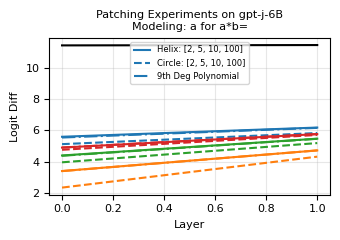

In [91]:

def plot_intervention_results(metric = 'logit_diff', target = 'a'):
    data = load_intervention_results(target)

    plt.figure(figsize=(3.5, 2.5))
    #toplots = ['pca', 'helix', 'circle', 'poly']
    toplots = ['loghelix', 'logcircle', 'logpoly']
    colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e']  # Standard matplotlib colors
    linestyles = ['-', '--', '-.', ':']
    for i, num_params in enumerate([9,7,5,3]):
        fits = get_best(num_params)
        for j, toplot in enumerate(toplots):
            best_fit = fits[toplot]
            values = data[best_fit][metric]
            label = split_helix_type(best_fit)
            if num_params == 9:
                plt.plot(values, color=colors[i], linestyle=linestyles[j], 
                    label=label)
            elif toplot == 'helix':
                plt.plot(values, color=colors[i], linestyle=linestyles[j], 
                    label=f'{num_params} Params\n{label}')
            else:
                plt.plot(values, color=colors[i], linestyle=linestyles[j])
    plt.plot(data['exchange'][metric], color='k', linestyle='-')
    plt.xlabel('Layer')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'Patching Experiments on {MODEL_NAME}\nModeling: {target} for a{op}b=')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save figure
    save_dir = 'figs/helix_intervention'
    os.makedirs(save_dir, exist_ok=True)
    save_path = f'{save_dir}/{metric}_by_layer_target_{target}_{MODEL_NAME}.png'
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi = 300)
    plt.show()
    plt.close()

#MODEL_NAME = 'pythia-6.9b'#'Llama-3.1-8B''gpt-j-6B'#
MODEL_NAME = 'gpt-j-6B'#
plot_intervention_results(metric = 'logit_diff')

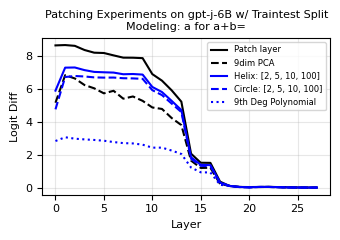

In [13]:
def plot_traintest_intervention_results(metric = 'logit_diff', target = 'a'):
    data = load_intervention_results(target, traintest = True)

    plt.figure(figsize=(3.5, 2.5))
    plt.plot(data['exchange'][metric], color='k', linestyle='-', label = 'Patch layer')
    for j, key in enumerate(data.keys()):
        if key == 'exchange':
            continue
        values = data[key][metric]
        label = split_helix_type(key)
        if 'pca' in key:
            plt.plot(values, color='black', linestyle='--', label=label)
        elif 'helix' in key:
            plt.plot(values, color='blue', linestyle='-', label=label)
        elif 'circle' in key:
            plt.plot(values, color='blue', linestyle='--', label=label)
        elif 'poly' in key:
            plt.plot(values, color='blue', linestyle=':', label=label)
    
    plt.xlabel('Layer')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'Patching Experiments on {MODEL_NAME} w/ Traintest Split\nModeling: {target} for a+b=')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save figure
    save_dir = 'figs/helix_intervention'
    os.makedirs(save_dir, exist_ok=True)
    save_path = f'{save_dir}/{metric}_traintest_layer_target_{target}_{MODEL_NAME}.png'
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi = 300)
    plt.show()
    plt.close()

#MODEL_NAME = 'gpt-j-6B'
plot_traintest_intervention_results(metric = 'logit_diff')

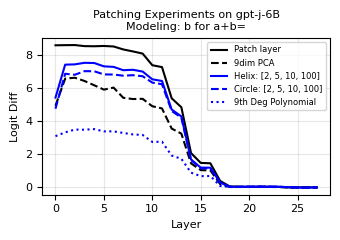

In [11]:
def plot_b_intervention_results(metric = 'logit_diff', target = 'b'):
    data = load_intervention_results(target, traintest = False)

    plt.figure(figsize=(3.5, 2.5))
    plt.plot(data['exchange'][metric], color='k', linestyle='-', label = 'Patch layer')
    for j, key in enumerate(data.keys()):
        if key == 'exchange':
            continue
        values = data[key][metric]
        label = split_helix_type(key)
        if 'pca' in key:
            plt.plot(values, color='black', linestyle='--', label=label)
        elif 'helix' in key:
            plt.plot(values, color='blue', linestyle='-', label=label)
        elif 'circle' in key:
            plt.plot(values, color='blue', linestyle='--', label=label)
        elif 'poly' in key:
            plt.plot(values, color='blue', linestyle=':', label=label)
    plt.xlabel('Layer')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'Patching Experiments on {MODEL_NAME}\nModeling: {target} for a+b=')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save figure
    save_dir = 'figs/helix_intervention'
    os.makedirs(save_dir, exist_ok=True)
    save_path = f'{save_dir}/{metric}_layer_target_{target}_{MODEL_NAME}.png'
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi = 300)
    plt.show()
    plt.close()

#MODEL_NAME = 'gpt-j-6B'
plot_b_intervention_results(metric = 'logit_diff')

exchange
pca_9
helix_a_[2, 5, 10, 100]
helix_a_[2, 5, 10, 100]_random


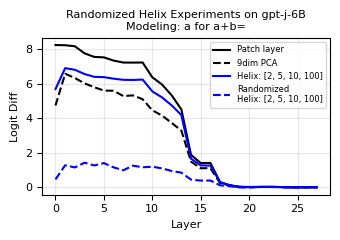

In [41]:

def plot_random_intervention_results(metric = 'logit_diff', target = 'a'):
    data = load_intervention_results(target, traintest = False, random = True)

    plt.figure(figsize=(3.5, 2.5))
    plt.plot(data['exchange'][metric], color='k', linestyle='-', label = 'Patch layer')
    for j, key in enumerate(data.keys()):
        print(key)
        if key == 'exchange':
            continue
        values = data[key][metric]
        label = split_helix_type(key)
        if 'pca' in key:
            plt.plot(values, color='black', linestyle='--', label=label)
        elif 'helix' in key:
            linestyle = '-'
            if 'random' in key:
                label = f'Randomized\n{label}'
                linestyle = '--'
            plt.plot(values, color='blue', linestyle=linestyle, label=label)
    
    plt.xlabel('Layer')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'Randomized Helix Experiments on {MODEL_NAME}\nModeling: {target} for a+b=')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save figure
    save_dir = 'figs/helix_intervention'
    os.makedirs(save_dir, exist_ok=True)
    save_path = f'{save_dir}/{metric}_layer_target_{target}_{MODEL_NAME}_random.png'
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi = 300)
    plt.show()
    plt.close()

#MODEL_NAME = 'gpt-j-6B'
plot_random_intervention_results(metric = 'logit_diff')

# Plot Random

In [5]:
def find_fit(helix_type, layer, traintest = False):
    save_dir = f'data_{OPERATION}/helix_fit/trained_fit'
    save_path = f"{save_dir}/{helix_type}/{helix_type}_fit_layer{layer}_{MODEL_NAME}{'_traintest' if traintest else ''}.pkl"
    with open(save_path, 'rb') as f:
        data = pickle.load(f)
    return data

data = find_fit('helix_a_[2, 5, 10, 100]_random', 20)
data.keys()

dict_keys(['a', 'b', 'a+b', 'predictions_full', 'A_map', 'pca_mean'])